In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
from skimage.feature import hog

In [4]:
from scipy.ndimage.measurements import label

In [5]:
#from skimage.measure import label, regionprops

### Define a function to draw rectangle box

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

### Define a function to extract color histogram features 

In [7]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

### Define a function to transform image's format , size and finally extract the image's pixel features

In [8]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

### Transform the  '.png' format of train dataset to '.jpeg' format.
My train dataset is from 'KITTI_extracted'(vehicles) and 'Extras'(non-vehicles), I found training with .png data cost more time than that with .jpeg data, the .png data format with float type range from 0 to 1,I think maybe the reason is float type compute more complicated. The code as follow, consider it ran only once, I commented out.

In [9]:
# import re

# dirpath = glob.glob('./backup/*/*.png')

# for fname in dirpath:
#     image = mpimg.imread(fname)
#     newname =  re.split(r'[\\/]',fname)
#     newname = newname[-1]
#     newname = newname.replace('.png','.jpeg')
#     savepath = './train_images/'+newname
#     mpimg.imsave(savepath,image)


### Load and classify the train dataset to 'cars' and 'notcars' 

In [10]:
cars = []
notcars = []
dirpath = glob.glob('./train_samples/*.jpeg')
for filename in dirpath:
    if 'extra' in filename or 'image' in filename :
        notcars.append(filename)
    else:
        cars.append(filename)

### I add some new cars samples cut from the test image and resize them
these new samples I cut them from the test images,mainly the white cars, I found the model seems can not identify the car with white color exactly consider the code ran only once, I commented out.

In [11]:
### this code for resize the 'adding new images' for 'cars'
### it only run once.
# dirpath = glob.glob('./add_images/*.jpg')

# for filename in dirpath:
#     savepath ='./resize_images/'
#     newname =  re.split(r'[\\/]',filename)
#     newname = newname[-1]
#     newname = newname.replace('.jpg','.jpeg')
#     savepath = savepath+newname
#     image = mpimg.imread(filename)
#     image = cv2.resize(image,(64,64))
#     mpimg.imsave(savepath,image)

### the length of train dataset

In [12]:
len(notcars)

5794

In [13]:
len(cars)

5998

### Define a function to return some characteristics of the dataset

Your function returned a count of 5998  cars and 5794  non-cars
of size:  (64, 64, 4)  and data type: uint8


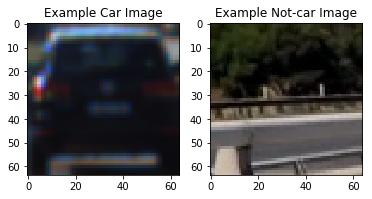

In [14]:
 

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

### Define a function to get the image's hog features.
I found the default parameter 'block_norm'=L1 will send a warning message when ran it,so I change it to 'L1-sqrt',I found the value of 'block_norm' has some effects to the train result.

In [15]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), block_norm='L1-sqrt',
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),block_norm='L1-sqrt',
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

### define a function for extract both color hist and hog features from a image
Same as the function 'extract_features_batch',this function is for extract features from the images which to be predicted 

In [16]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,hog_color='RGB'):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_color != 'RGB':
                if hog_color == 'HSV':
                    hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                elif hog_color == 'LUV':
                    hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
                elif hog_color == 'HLS':
                    hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
                elif hog_color == 'YUV':
                    hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
                elif hog_color == 'YCrCb':
                    hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
                elif hog_color == 'Gray':
                    hog_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                    hog_img = hog_img.reshape(hog_img.shape[0],hog_img.shape[1],1)
        else: hog_img = np.copy(img)      
        
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(hog_img.shape[2]):
                hog_features.extend(get_hog_features(hog_img[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(hog_img[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

### define a function for extract both color hist and hog features with a image list.
this function is for training model with batch images.I make some modify from the class video's example code.I add the hog_color parameter to test and finetune the train model with different hog and color hist method parameter. 

In [17]:
def extract_features_batch(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True,hog_color='RGB'):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_color != 'RGB':
                if hog_color == 'HSV':
                    hog_img = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif hog_color == 'LUV':
                    hog_img = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif hog_color == 'HLS':
                    hog_img = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif hog_color == 'YUV':
                    hog_img = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif hog_color == 'YCrCb':
                    hog_img = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
                elif hog_color == 'Gray':
                    hog_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                    hog_img = hog_img.reshape(hog_img.shape[0],hog_img.shape[1],1)
            else: hog_img = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(hog_img.shape[2]):
                    hog_features.append(get_hog_features(hog_img[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(hog_img[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### I shuffle and pick 5700 images from  the train dataset  for train and test

In [18]:
from sklearn.utils import shuffle 
cars = shuffle(cars)
notcars = shuffle(notcars)
sample_size = 5700
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### I define the global  variable here

In [83]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb and Gray
hog_color='YUV' ;
orient = 11
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins =16    # Number of histogram bins
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins =16    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

### Train the classifier 
The classifier I finally use to generate the video is trained only by HOG hist features.
I used a linear SVM classifier to do the classify job,and set the c value as 0.001.It performed not bad.

In [84]:
car_features = extract_features_batch(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,hog_color = hog_color)
notcar_features = extract_features_batch(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat,hog_color = hog_color)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=0.001)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 5))
# Check the prediction time for a single sample
t=time.time()

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
0.3 Seconds to train SVC...
Test Accuracy of SVC =  1.0


### Define a function to find cars in Hog Sub-sampling Window Search method
This code only has to extract hog features once and then can be sub-sampled to get all of its overlaying windows

In [85]:
def find_cars_mod(img, ystart, ystop, scale, svc, X_scaler, orient, 
                  pix_per_cell, cell_per_block, spatial_size, hist_bins,
                  hog_channel='ALL',spatial_feat=True,hist_feat = True,
                  color_space='RGB' ,hog_color = 'RGB',retimg =0):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    boxset = []
    threshold =[]
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv=hog_color)
    ctrans_tosearch_chist = convert_color(img_tosearch, conv=color_space)
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        ctrans_tosearch_chist = cv2.resize(ctrans_tosearch_chist, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))


    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = np.array([])
    hog2 = np.array([])
    hog3 = np.array([])
    
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel == 0 :
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel ==1:
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    elif hog_channel ==2:
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = np.array([])
            hog_feat2 =np.array([])
            hog_feat3 =np.array([])
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                
            elif hog_channel == 0 :
                 hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 1 :
                 hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            elif hog_channel == 2 :
                 hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))  
      
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            subimg_hist = cv2.resize(ctrans_tosearch_chist[ytop:ytop+window, xleft:xleft+window], (64,64))
            # Get color features
            spatial_features = np.array([])
            hist_features =np.array([])
            if spatial_feat == True :
                spatial_features = bin_spatial(subimg_hist, size=spatial_size)
            if hist_feat==True:
                hist_features = color_hist(subimg_hist, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
           
           
            if test_prediction == 1:
                threshold.append(svc.decision_function(test_features))
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if retimg !=1:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxset.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    if(len(threshold)>0):
        threshold = np.concatenate(threshold)
        
    if retimg == 0:
        return draw_img
    elif retimg == 1:
        return boxset,threshold
    elif retimg ==2:
        return draw_img,boxset

### Convert the image's color space
I add the key word 'Gray' to test grayscale's performance in hog features classify mode.It just used for testing 

In [86]:
def convert_color(img, conv='RGB'):
    if conv != 'RGB':
        if conv == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif conv == 'Gray':
            hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            hog_img = np.dstack((hog_img,hog_img,hog_img))
            return hog_img
            
    else: 
        return np.copy(img)    

### Define a function to apply multi-scale vehicle detection. 
The parameter scalelist is restore a list of scale value, and the parameter 'ispaint' is determine whether to draw the box or not.
The parameter 'retsingle' is to determine whether to return a single-scale result and the single-scale = retscale,is used to debug and observe the performance of classifier in solid scale value.

In [87]:
def drawcars (img, ystart, ystop, scalelist, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins,hog_channel,spatial_feat,
              hist_feat,color_space,hog_color,ispaint= True,retsingle = False,retscale = 1.2):
    drawset = []
    out_img = np.copy(img)
    single =None
    s_img = None
    thr = []
    for scale in scalelist:
        boxset,thri = find_cars_mod(img=out_img, ystart=ystart, ystop=ystop, scale=scale, svc=svc, X_scaler=X_scaler, orient =orient, 
                               pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, spatial_size=spatial_size, 
                               hist_bins=hist_bins,hog_channel= hog_channel,spatial_feat = spatial_feat,hist_feat=hist_feat,
                               color_space=color_space ,hog_color=hog_color,retimg =1)
        thr.append(thri)
        if(retsingle==True):
            if(scale==retscale):
                single = boxset
        drawset = drawset + boxset
    for box in drawset:
        cv2.rectangle(out_img, box[0], box[1], (0,0,255),6)
    if(retsingle==True):
        if single != None:
            s_img = np.copy(img)
            for box in single:
                 cv2.rectangle(s_img, box[0], box[1], (0,0,255),6)
    
    
    if(ispaint==True):
        if(retsingle==True):
            return out_img,drawset,s_img,single,thr
        else:
            return out_img,drawset
    else:
        
        return drawset
  
        
    

### Define  a function to add heat map 

In [88]:


def add_heat(img, bbox_list):
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

### Define a function to add a threshold to the heat map

In [89]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

### Define a function to draw the all the detected heatmap box
I add a parameter 'filtersize' to filter the tiny false positives detected.
In this project,the initial slide window is 64x64,and it means a tiny heatmap box may imply false positives.

In [90]:
def draw_labeled_bboxes(img, labels,filtersize =None,retimg = True):
    # Iterate through all detected cars

    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if(filtersize==None):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        else:
            if(len(nonzerox)<filtersize):
                pass
            else:
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
                
    # Return the image
    return img

### Define a function to return all the detected heatmap boxes' position
This function mainly use for the consecutive frame video cars detected

In [91]:
def get_frame_bbox(labels,filtersize=None):
    frameboxset =[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        if(filtersize==None):
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            frameboxset.append(bbox)
        else:
            if(len(nonzerox)<filtersize):
                pass
            else:
                bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
                frameboxset.append(bbox)
                
    # Return the image
    return frameboxset
    

### Define a function for the test image cars detected pipeline
I used a dict to record the intermediate result of every step
* the keyword 'origin' : the original image.
* the keyword 'single_scale': set the scale factor as 1.2. 
* the keyword 'multi_scale': detect operation in multiple slide window sizes.
* the keyword 'heatmap':record the heatmap after multi-scale detected.
* the keyword 'thresh': the heatmap result after threshold filter.
* the keyword 'final': the finally result.

In [97]:
def pipeline_test (img):
    intermediate = {'origin':None,'single_scale':None,'multi_scale':None,'heatmap':None,'thresh':None,'final':None}
    out_img,drawset,s_img,_,thr = drawcars (img=img, ystart=ystart, ystop= ystop, scalelist=scalelist, svc=svc, 
                                            X_scaler=X_scaler ,orient = orient, pix_per_cell = pix_per_cell, 
                                            cell_per_block =cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins,
                                            hog_channel=hog_channel ,spatial_feat=spatial_feat,hist_feat=hist_feat,
                                            color_space=color_space,hog_color=hog_color,ispaint=True,retsingle=True)
    intermediate['origin'] = img
    intermediate['single_scale'] = s_img
    intermediate['multi_scale'] = out_img
    heatmap = add_heat(img,drawset)
    intermediate['heatmap'] = heatmap
    heatmap= apply_threshold(heatmap,0)
    intermediate['thresh'] = heatmap
    labels = label(heatmap)
    final_img = np.copy(img)
    final_img = draw_labeled_bboxes(final_img,labels,filtersize =900)
    intermediate['final'] = final_img
     
    return intermediate,labels,thr
    

### Define a class for video cars detected pipeline.
Different from the test image, video scene need to consider how to reduce false positives in consecutive frames,because the test images are static and clear,and detect operation in these test images is easy to find the cars,but in video scene, not all the clipped images are clear,maybe some bad frames in it,and these bad frames could cause false positives.
to solve this problem,consider most of these false positives in consecutive frames are random noise,so most of time,these can not appear in roughly same position in several consecutive frames,but the car's position are stable,so it can use a heatmap threshold method to filter these false positives,my method is that: use the heat map twice: scan and get the heatmap boxes in current frame,and do the heatmap operation again in several consecutive frame, get the finally heatmap.


In [93]:
from collections import deque

In [103]:
class videoprocess():
    def __init__(self):
        N = 5
        self.result = None # restore the finally result.
        self.img = None # the current image.
        self.heatbox = deque(maxlen = N)
        # restore the heatmap box in several frame.
            
        self.frameboxset =[] # the current frame detected box 
        self.meanset =[] # the heatmap over several frame heatmap(the twice heatmap result) 
        self.labels =None # the current frame heatmap labels
        self.meanlabels = None # the heatmap labels with twice heatmap
    
    def getdrawbox(self,img):# get the heatmap in current frame.
        self.img = img
        drawset = drawcars (img=img, ystart=ystart, ystop= ystop, scalelist=scalelist, svc=svc, X_scaler=X_scaler ,
                            orient = orient, pix_per_cell = pix_per_cell, cell_per_block =cell_per_block, 
                            spatial_size=spatial_size, hist_bins=hist_bins,hog_channel=hog_channel ,
                            spatial_feat=spatial_feat,hist_feat=hist_feat,color_space=color_space,hog_color=hog_color,
                            ispaint=False,retsingle=False)
        heatmap = add_heat(img,drawset)
        heatmap= apply_threshold(heatmap,0)
        labels = label(heatmap)
        self.frameboxset = get_frame_bbox(labels)
        self.heatbox.append(self.frameboxset)
        self.labels = labels
    def getheatmap(self):# do the second threshold heatmap with several frames heatmap results.
        if len(self.heatbox)==5:
            boxlist =[]
            for boxset in self.heatbox:
                boxlist = boxlist + boxset
            heatmap = add_heat(self.img,boxlist)
            heatmap = apply_threshold(heatmap,0)
            labels = label(heatmap)
            self.meanset = get_frame_bbox(labels)
            self.meanlabels = labels
        else:
            self.meanset = self.frameboxset
            self.meanlabels = self.labels
            
    def pipeline(self,img):# finally filter the tiny false positives which area less than 1500 square pixels
        self.getdrawbox(img)
        self.getheatmap()
        drawimg = np.copy(img)
        self.result = draw_labeled_bboxes(drawimg,self.meanlabels,filtersize=1500)
        return self.result
            
        
        

### Show every step result of the test images

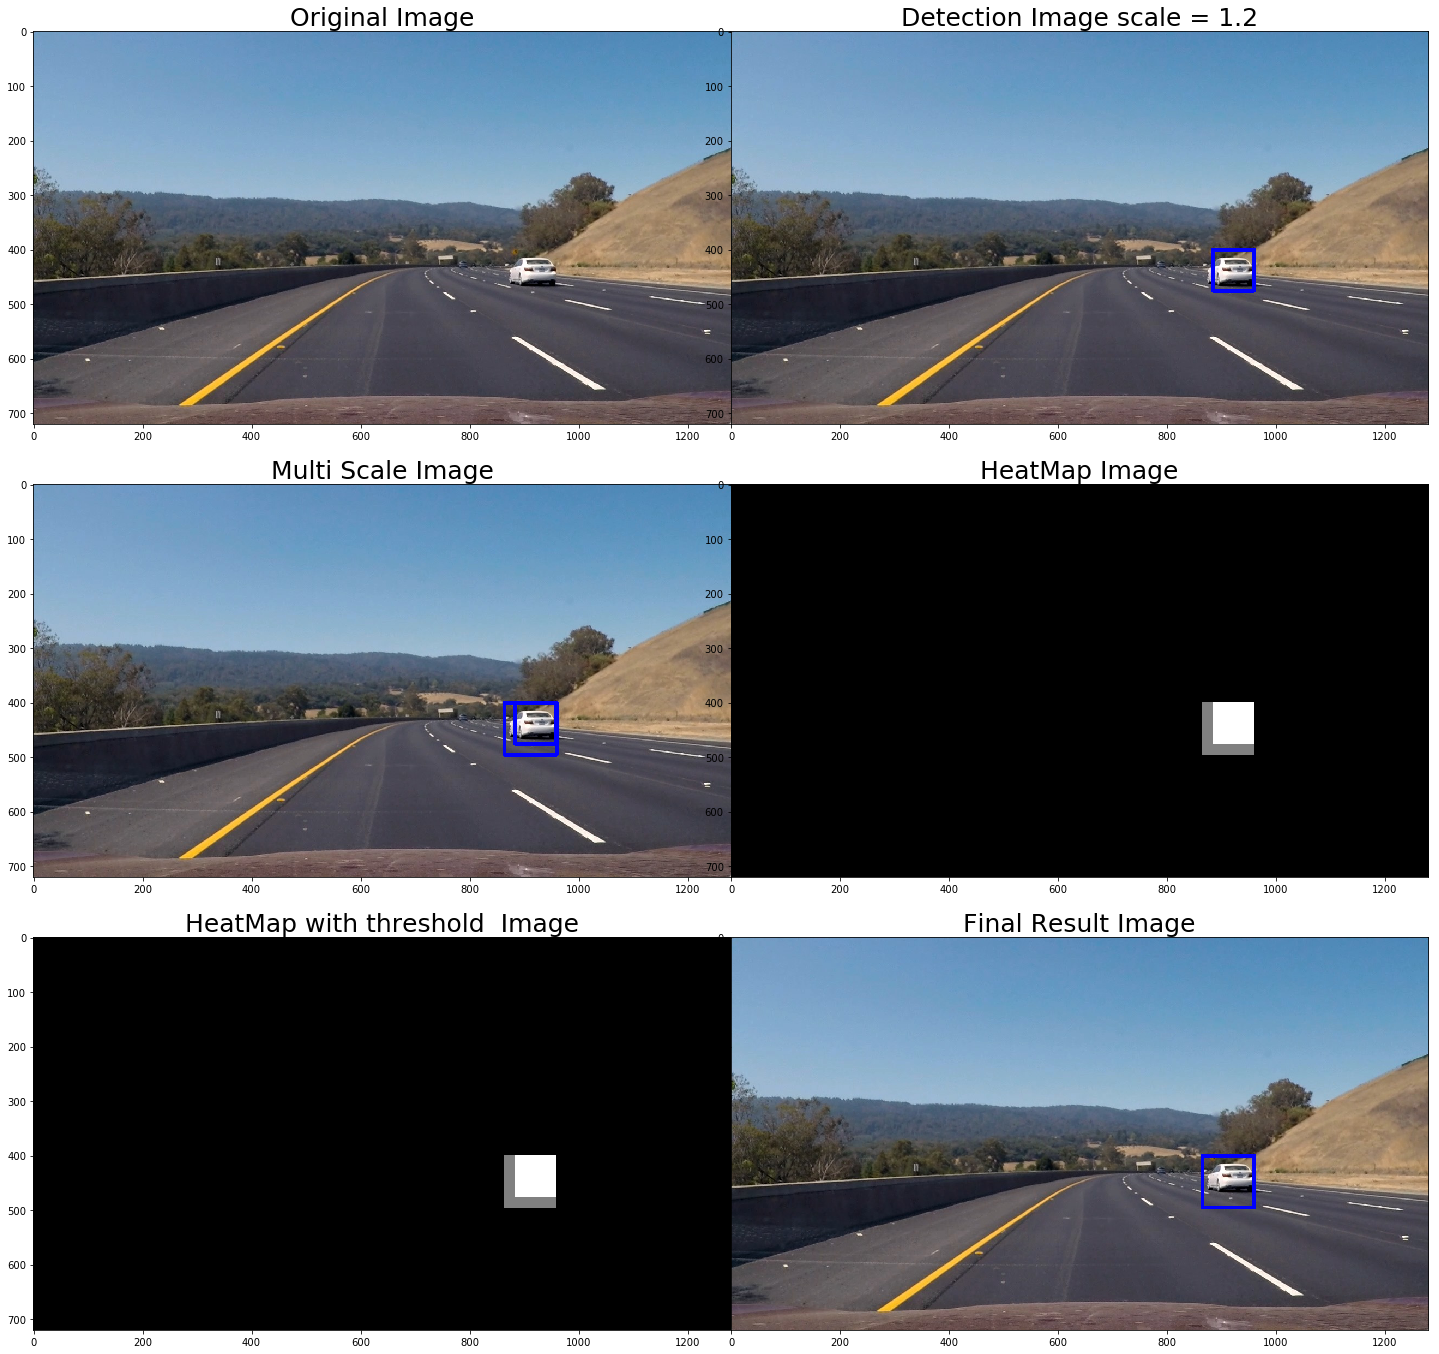

In [114]:
ystart = 400
ystop = 656
testimg = mpimg.imread('./test_images/test3.jpg')
scalelist = [1.2,1.5,1.8,2.0]
intermediate,labels,thr = pipeline_test(testimg)
fig = plt.figure(figsize=(25,25))
plt.subplot(321)
plt.imshow(intermediate['origin'])
plt.title('Original Image',fontsize=25)
plt.subplot(322)
plt.imshow(intermediate['single_scale'])
plt.title('Detection Image scale = 1.2',fontsize=25)
plt.subplot(323)
plt.imshow(intermediate['multi_scale'])
plt.title('Multi Scale Image',fontsize=25)
plt.subplot(324)
plt.imshow(intermediate['heatmap'],cmap='gray')
plt.title('HeatMap Image',fontsize=25)
plt.subplot(325)
plt.imshow(intermediate['thresh'],cmap='gray')
plt.title('HeatMap with threshold  Image',fontsize=25)
plt.subplot(326)
plt.imshow(intermediate['final'])
plt.title('Final Result Image',fontsize=25)
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


In [32]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
white_output = './project_videos_output/project_video_yuv.mp4'
video_carsdetect =videoprocess()
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(video_carsdetect.pipeline) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./project_videos_output/project_video_yuv.mp4
[MoviePy] Writing video ./project_videos_output/project_video_yuv.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [14:22<00:00,  1.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_videos_output/project_video_yuv.mp4 

Wall time: 14min 23s


#### The code below used to clip a  segment of the video for test purpose

In [31]:
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML
# video_carsdetect =videoprocess()
# clip1 = VideoFileClip("./project_video.mp4").subclip(25, 30)
# white_clip = clip1.fl_image(video_carsdetect.pipeline)
# white_clip = white_clip.resize(width=320)
# white_clip.write_gif("sample_25-30.gif", fps=25)